In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
# En caso de que se ejecute clonando el repositorio

DATA_DIR = Path.cwd().resolve().parent / "datos"

datos_titanic = pd.read_parquet(DATA_DIR / "02_datos_con_tipo_de_dato_ajustado_titanic.parquet", engine="pyarrow")

## Selección de Columnas y Estructura del DataFrame

In [3]:
columnas_seleccionadas = [
    "pclass",
    "sex",
    "age",
    "sibsp",
    "parch",
    "fare",
    "embarked",
    "survived",
]

In [4]:
df_titanic = datos_titanic[columnas_seleccionadas]

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   int64   
 1   sex       1309 non-null   category
 2   age       1046 non-null   float64 
 3   sibsp     1309 non-null   int8    
 4   parch     1309 non-null   int8    
 5   fare      1308 non-null   float64 
 6   embarked  1307 non-null   category
 7   survived  1309 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(1), int8(2)
memory usage: 37.5 KB


# AutoML con FLAML

A continuación, se muestra un ejemplo **completamente documentado** sobre cómo usar [FLAML](https://microsoft.github.io/FLAML/) (Fast Lightweight AutoML) para llevar a cabo un proceso de **optimización automática de modelos**.

## ¿Qué es FLAML?

**FLAML** es una biblioteca de AutoML desarrollada por Microsoft que se destaca por:
- **Eficiencia**: Usa un algoritmo de búsqueda económico que reduce costos computacionales
- **Flexibilidad**: Compatible con scikit-learn, XGBoost, LightGBM, CatBoost, etc.
- **Optimización Inteligente**: Busca automáticamente el mejor modelo y sus hiperparámetros
- **Control del Usuario**: Permite definir presupuesto de tiempo, métricas personalizadas, etc.

## Diferencia con PyCaret

A diferencia de PyCaret que automatiza **todo** el proceso (preprocesamiento + modelado), FLAML se enfoca principalmente en la **optimización del modelo**. Esto significa que:
- **Tú controlas el preprocesamiento** usando herramientas como `ColumnTransformer` y `Pipeline` de scikit-learn
- **FLAML optimiza** la selección del modelo y sus hiperparámetros de manera eficiente

Esto te da más control y transparencia sobre cada paso del proceso.

## Preparación de Datos

Primero separamos las características (X) de la variable objetivo (y), y dividimos en entrenamiento y prueba.

In [5]:
from sklearn.model_selection import train_test_split

# Separar características y objetivo
X = df_titanic.drop(columns=["survived"])
y = df_titanic["survived"].astype(int)  # FLAML requiere valores numéricos para clasificación binaria

# División entrenamiento-prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Conjunto de entrenamiento: 1047 muestras
Conjunto de prueba: 262 muestras


## Preprocesamiento con Pipeline de scikit-learn

Definimos un pipeline de preprocesamiento que:
1. **Imputa valores faltantes** en columnas numéricas (con la mediana)
2. **Codifica variables ordinales** (pclass tiene orden: 1 < 2 < 3)
3. **Codifica variables categóricas** (sex, embarked) con One-Hot Encoding

Este pipeline será usado por FLAML automáticamente.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Definir las columnas por tipo
numeric_features = ["age", "fare", "sibsp", "parch"]
ordinal_features = ["pclass"]
categorical_features = ["sex", "embarked"]

# Pipeline para variables numéricas: imputación con mediana
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline para variable ordinal: imputación + encoding ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[[1, 2, 3]]))
])

# Pipeline para variables categóricas: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # drop='first' evita multicolinealidad
])

# Combinar todos los transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pipeline de preprocesamiento creado correctamente")

Pipeline de preprocesamiento creado correctamente


## Configuración y Entrenamiento con FLAML

Ahora usamos **FLAML AutoML** para:
- Buscar automáticamente entre múltiples algoritmos (LogisticRegression, RandomForest, XGBoost, LightGBM, etc.)
- Optimizar los hiperparámetros de cada modelo
- Encontrar la mejor combinación en un tiempo determinado

### Parámetros clave:
- `task`: tipo de problema ('classification' o 'regression')
- `metric`: métrica a optimizar (ej: 'accuracy', 'roc_auc', 'f1')
- `time_budget`: presupuesto de tiempo en segundos
- `estimator_list`: lista de modelos a considerar
- `seed`: semilla para reproducibilidad

In [7]:
from flaml import AutoML
from sklearn.pipeline import Pipeline as SklearnPipeline

# Crear instancia de FLAML AutoML
automl = AutoML()

print("FLAML AutoML inicializado")

FLAML AutoML inicializado


In [8]:
# Aplicar preprocesamiento a los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Configurar y entrenar FLAML
automl_settings = {
    "time_budget": 60,  # Presupuesto de tiempo: 120 segundos (2 minutos)
    "metric": 'accuracy',  # Métrica a optimizar
    "task": 'classification',  # Tipo de tarea
    "estimator_list": ['lgbm', 'rf', 'xgboost', 'extra_tree', 'lrl1'],  # Modelos a probar
    "log_file_name": 'flaml_titanic.log',  # Archivo de registro
    "seed": 42,  # Semilla para reproducibilidad
    "verbose": 3  # Nivel de verbosidad (0-5, siendo 5 el más detallado)
}

print("Iniciando búsqueda automática de modelos con FLAML...")
print("="*60)

# Entrenar
automl.fit(X_train_preprocessed, y_train, **automl_settings)

print("="*60)
print("Búsqueda completada!")

Iniciando búsqueda automática de modelos con FLAML...
[flaml.automl.logger: 10-20 07:10:12] {1752} INFO - task = classification
[flaml.automl.logger: 10-20 07:10:12] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-20 07:10:12] {1862} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 10-20 07:10:12] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl.logger: 10-20 07:10:12] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-20 07:10:12] {2417} INFO - Estimated sufficient time budget=348s. Estimated necessary time budget=6s.
[flaml.automl.logger: 10-20 07:10:12] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2254,	best estimator lgbm's best error=0.2254
[flaml.automl.logger: 10-20 07:10:12] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-20 07:10:12] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2254,	best estimator lgbm's best error=0.2254


## Resultados del Mejor Modelo

FLAML automáticamente selecciona el mejor modelo encontrado durante la búsqueda.

In [9]:
# Mostrar información del mejor modelo encontrado
print("Mejor modelo encontrado:", automl.best_estimator)
print("\nHiperparámetros del mejor modelo:")
print(automl.best_config)
print("\nMejor loss (error de validación):", automl.best_loss)
print("Accuracy estimado en validación:", 1 - automl.best_loss)
print("\nTiempo total de búsqueda:", automl.time_to_find_best_model, "segundos")

Mejor modelo encontrado: lgbm

Hiperparámetros del mejor modelo:
{'n_estimators': 4, 'num_leaves': 6, 'min_child_samples': 27, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.8059029452255674, 'reg_alpha': 0.0016453415742803139, 'reg_lambda': 11.097048723386715}

Mejor loss (error de validación): 0.19486899065846436
Accuracy estimado en validación: 0.8051310093415356

Tiempo total de búsqueda: 21.415465831756592 segundos


## Evaluación en Conjunto de Prueba

Ahora evaluamos el mejor modelo en datos no vistos (conjunto de prueba).

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Hacer predicciones en el conjunto de prueba
y_pred = automl.predict(X_test_preprocessed)
y_pred_proba = automl.predict_proba(X_test_preprocessed)[:, 1]  # Probabilidades de la clase 1

# Calcular accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en conjunto de prueba: {test_accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Sobrevivió', 'Sobrevivió']))

Accuracy en conjunto de prueba: 0.8435

Reporte de clasificación:
               precision    recall  f1-score   support

No Sobrevivió       0.84      0.92      0.88       162
   Sobrevivió       0.85      0.72      0.78       100

     accuracy                           0.84       262
    macro avg       0.84      0.82      0.83       262
 weighted avg       0.84      0.84      0.84       262



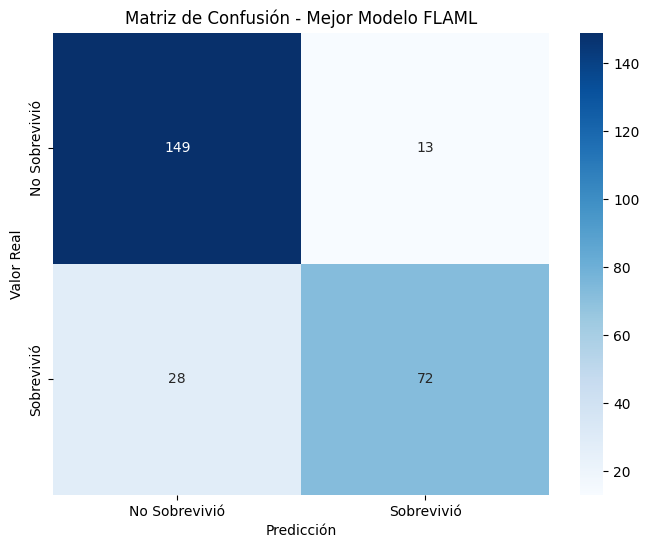

In [11]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Sobrevivió', 'Sobrevivió'],
            yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Mejor Modelo FLAML')
plt.show()

## Entendiendo las Probabilidades de Predicción

Al igual que en PyCaret, FLAML también genera **probabilidades** (confianza) para cada predicción:

- **Probabilidad cerca de 1.0**: El modelo está muy seguro de que la persona sobrevivió
- **Probabilidad cerca de 0.0**: El modelo está muy seguro de que la persona NO sobrevivió
- **Probabilidad cerca de 0.5**: El modelo está indeciso

Por defecto, se usa un umbral de 0.5 para convertir probabilidades en predicciones binarias.

In [12]:
# Crear DataFrame con predicciones
df_predictions = X_test.copy()
df_predictions['survived_real'] = y_test.values
df_predictions['prediction_label'] = y_pred
df_predictions['prediction_score'] = y_pred_proba

# Mostrar algunos ejemplos
print("Ejemplos de predicciones:")
print(df_predictions[['pclass', 'sex', 'age', 'survived_real', 'prediction_label', 'prediction_score']].head(10))

Ejemplos de predicciones:
      pclass     sex   age  survived_real  prediction_label  prediction_score
1028       3  female   NaN              1                 0          0.347765
1121       3    male   NaN              1                 0          0.255853
1155       3    male   NaN              0                 0          0.124254
1251       3    male  30.5              0                 0          0.188072
721        3    male  36.0              0                 0          0.188072
1157       3    male  18.0              0                 0          0.171879
512        2    male  32.5              0                 0          0.270413
20         1    male  37.0              1                 0          0.331726
50         1  female  58.0              1                 1          0.833827
983        3    male   NaN              0                 0          0.124254


## Probar el Modelo en Datos Sintéticos

Generamos datos sintéticos para probar cómo se comporta el modelo con nuevas muestras.

In [13]:
# Número de muestras sintéticas
np.random.seed(57)

n_samples = 50

# Generar datos sintéticos siguiendo la estructura del dataset Titanic
df_synthetic_test = pd.DataFrame({
    "pclass": np.random.choice([1, 2, 3], size=n_samples),
    "sex": np.random.choice(["male", "female"], size=n_samples),
    "age": np.random.uniform(0, 80, size=n_samples),
    "sibsp": np.random.randint(0, 4, size=n_samples),
    "parch": np.random.randint(0, 4, size=n_samples),
    "fare": np.random.uniform(10, 100, size=n_samples),
    "embarked": np.random.choice(["C", "Q", "S"], size=n_samples)
})

# Mostrar los primeros registros para verificar
df_synthetic_test.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,29.549676,2,2,87.460519,C
1,2,male,22.782733,2,1,81.690288,S
2,3,male,74.169372,1,2,51.914214,Q
3,1,male,62.041734,3,2,74.020331,Q
4,3,male,51.305236,0,0,26.458023,S


In [14]:
# Aplicar preprocesamiento a los datos sintéticos
X_synthetic_preprocessed = preprocessor.transform(df_synthetic_test)

# Hacer predicciones
synthetic_predictions = automl.predict(X_synthetic_preprocessed)
synthetic_proba = automl.predict_proba(X_synthetic_preprocessed)[:, 1]

# Agregar predicciones al DataFrame
df_synthetic_test['prediction_label'] = synthetic_predictions
df_synthetic_test['prediction_score'] = synthetic_proba

# Mostrar resultados
print("Predicciones en datos sintéticos:")
df_synthetic_test.head(10)

Predicciones en datos sintéticos:


,pclass,sex,age,sibsp,parch,fare,embarked,prediction_label,prediction_score
0,3,male,29.549676,2,2,87.460519,C,0,0.295020
1,2,male,22.782733,2,1,81.690288,S,0,0.201675
2,3,male,74.169372,1,2,51.914214,Q,0,0.108540
3,1,male,62.041734,3,2,74.020331,Q,0,0.379197
4,3,male,51.305236,0,0,26.458023,S,0,0.114716
5,1,male,22.885028,2,1,75.375713,C,1,0.544131
6,1,male,53.178830,3,3,52.097022,C,0,0.217689
7,2,male,10.765465,3,3,97.775780,Q,1,0.509364
8,2,female,39.573028,2,2,75.901448,C,1,0.901940
9,2,male,51.739915,3,0,93.341945,S,0,0.150693


## Guardar el Modelo Completo

Es importante guardar **tanto el preprocesador como el modelo** para poder hacer predicciones en datos nuevos.

Creamos un pipeline completo que incluye ambos pasos.

In [16]:
# Crear pipeline completo: preprocesador + modelo
full_pipeline = SklearnPipeline([
    ('preprocessor', preprocessor),
    ('model', automl.model)  # El mejor modelo encontrado por FLAML
])

print("Pipeline completo creado:")
print(full_pipeline)

Pipeline completo creado:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'fare', 'sibsp',
                                                   'parch']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[[1,
                                                                                               2,
                                               

In [ ]:
#TODO: Cambiar la ubicación de guardado

import joblib

# Guardar el pipeline completo
model_filename = 'flaml_titanic_model.joblib'
joblib.dump(full_pipeline, model_filename)

print(f"Modelo completo guardado en: {model_filename}")

Modelo completo guardado en: flaml_titanic_model.joblib


## Cargar el Modelo Guardado

Podemos cargar el modelo guardado y usarlo directamente en datos nuevos sin necesidad de preprocesar manualmente.

In [17]:
# Cargar el modelo
loaded_pipeline = joblib.load(model_filename)

# Probar con datos sintéticos SIN preprocesar
# El pipeline se encarga automáticamente del preprocesamiento
test_predictions = loaded_pipeline.predict(df_synthetic_test.drop(columns=['prediction_label', 'prediction_score']))

print("Predicciones con modelo cargado:")
print(test_predictions[:10])
print("\n✅ El modelo cargado funciona correctamente!")

Predicciones con modelo cargado:
[0 0 0 0 0 0 0 0 1 0]

✅ El modelo cargado funciona correctamente!


## Comparación: FLAML vs PyCaret

| Aspecto | PyCaret | FLAML |
|---------|---------|-------|
| **Preprocesamiento** | Automático | Manual (con sklearn) |
| **Optimización** | Grid/Random Search | Búsqueda económica (CFO) |
| **Control** | Menos control | Más control y transparencia |
| **Eficiencia** | Buena | Excelente (optimizado para rapidez) |
| **Flexibilidad** | Configuraciones predefinidas | Altamente personalizable |
| **Curva de aprendizaje** | Baja (fácil de usar) | Media (requiere conocer sklearn) |

### ¿Cuándo usar cada uno?

- **Usa PyCaret** cuando:
  - Necesitas resultados rápidos sin preocuparte por el preprocesamiento
  - Quieres explorar muchos modelos fácilmente
  - Eres principiante en ML

- **Usa FLAML** cuando:
  - Necesitas optimización eficiente con presupuesto limitado de tiempo
  - Quieres control total sobre el preprocesamiento
  - Buscas el mejor rendimiento posible en producción
  - Ya tienes experiencia con scikit-learn